In [1]:
import xarray as xr
import numpy  as np
import pandas as pd

# !pip install OpenVisusNoGui
import OpenVisus as ov

# see https://xarray.pydata.org/en/stable/internals/how-to-add-new-backend.html


# ////////////////////////////////////////////////////////////
class OpenVisusBackendArray(xr.backends.common.BackendArray):

    # constructor
    def __init__(self,db, shape, dtype, ncomponents):
        self.db    = db
        self.shape = shape
        self.dtype = dtype
        self.ncomponents=ncomponents
        self.pdim=db.getPointDim()

    # __getitem__
    def __getitem__(self, key: xr.core.indexing.ExplicitIndexer) -> np.typing.ArrayLike:
        return xr.core.indexing.explicit_indexing_adapter(key,self.shape,xr.core.indexing.IndexingSupport.BASIC,self._raw_indexing_method)

    # _getKeyRange
    def _getKeyRange(self, value):
        A = value.start if isinstance(value, slice) else value    ; A = 0             if A is None else A
        B = value.stop  if isinstance(value, slice) else value + 1; B = self.shape[1] if B is None else B
        return (A,B)

    # __readSamples
    def _raw_indexing_method(self, key: tuple) -> np.typing.ArrayLike:
        print("_raw_indexing_method","key",key)

        if self.pdim==2:
            y1,y2=self._getKeyRange(key[0])
            x1,x2=self._getKeyRange(key[1])
            data=self.db.read(logic_box=[(x1,y1),(x2,y2)])

        elif self.pdim==3:
            z1,z2=self._getKeyRange(key[0])
            y1,y2=self._getKeyRange(key[1])
            x1,x2=self._getKeyRange(key[2])
            data=self.db.read(logic_box=[(x1,y1,z1),(x2,y2,z2)])

        else:
            raise Exception("problem")

        # last key element is the channel
        if self.ncomponents>1:
            c1,c2=self._getKeyRange(key[-1])

            # Y,X,Channel
            if self.pdim==2:
                data=data[:,:,c1:c2]

            # Z,Y,X,Channel
            elif self.pdim==3:
                data=data[:,:,:,c1:c2]

            else:
                raise Exception("problem")

        return data




# ////////////////////////////////////////////////////////////
class OpenVisusBackendEntrypoint(xr.backends.common.BackendEntrypoint):

    open_dataset_parameters = ["filename_or_obj", "drop_variables", "resolution", "timesteps"]
    
    # open_dataset
    def open_dataset(self,filename_or_obj,*, resolution=None, timesteps=None, drop_variables=None):

        # TODO for now only full resoluton
        self.resolution=resolution

        # TODO for now only default timestep
        self.timesteps=timesteps

        data_vars={}

        db=ov.LoadDataset(filename_or_obj)

        dim=db.getPointDim()
        dims=db.getLogicSize()

#         print(db.getDatasetBody().toString())
#         print("dim",dim, "dims",dims)

        # convert OpenVisus fields into xarray variables
        for fieldname in db.getFields():
            field=db.getField(fieldname)
            
            ncomponents=field.dtype.ncomponents()
            atomic_dtype=field.dtype.get(0)

            # note: OpenVisus can have dtype uint8[3],numpy cannot
            # for this reason for example
            # 1024x768     uint8       becomes (768,1024)      np.uint8    (NOTE I don't have to add anything to the shape)
            # 1024x768     uint8[3]    becomes (768,1024,3)    np.uint8    (NOTE I am adding a '3' to the shape)
            # 100x200x300  float64     becomes (300,200,100)   np.float64  (NOTE I don't have to add anything to the shape)
            # 100x200x300  float64[2]  becomes (300,200,100,2) np.float64  (NOTE I am adding a '2' to the shape)

            dtype=self.toNumPyDType(atomic_dtype) 

            if dim==2:
                labels=["y", "x"]
            elif dim==3:
                labels=["z", "y", "x"]
            else:
                raise Exception(todo)

            shape=list(reversed(dims))
            if ncomponents>1:
                labels.append("channel")
                shape.append(ncomponents)

            data_vars[fieldname]=xr.Variable(
                labels, 
                xr.core.indexing.LazilyIndexedArray(OpenVisusBackendArray(db=db, shape=shape,dtype=dtype, ncomponents=ncomponents)), 
                attrs={} # no attributes
            )

            print("Adding field",fieldname,"shape",shape,"dtype",dtype,"labels",labels)

        ds = xr.Dataset(data_vars=data_vars)
        ds.set_close(self.close_method)
        return ds
    
    # toNumPyDType (always pass the atomic OpenVisus type i.e. uint8[8] should not be accepted)
    def toNumPyDType(self,atomic_dtype):
        """
        convert an Openvisus dtype to numpy dtype
        """

        # dtype  (<: little-endian, >: big-endian, |: not-relevant) ; integer providing the number of bytes  ; i (integer) u (unsigned integer) f (floating point)
        return np.dtype("".join([
            "|" if atomic_dtype.getBitSize()==8 else "<",
            "f" if atomic_dtype.isDecimal() else ("u" if atomic_dtype.isUnsigned() else "i"),
            str(int(atomic_dtype.getBitSize()/8))
        ])) 

    # close_method
    def close_method(self):
        print("nothing to do here")
    
    # guess_can_open
    def guess_can_open(self, filename_or_obj):
        print("guess_can_open",filename_or_obj)

        # this are remote datasets
        # todo: extend to S3 datasets
        if "mod_visus" in filename_or_obj:
            return True
         
        # local files
        try:
            _, ext = os.path.splitext(filename_or_obj)
        except TypeError:
            return False
        return ext.lower()==".idx"

ds = xr.open_dataset("http://atlantis.sci.utah.edu/mod_visus?dataset=BlueMarble", resolution=0,engine=OpenVisusBackendEntrypoint)

print("dtype",ds.data.dtype)
print("shape",ds.data.shape)
#print("first-sample",ds.data[0,0,:].values)
print("subregion",ds.data[0:3,1:3,:].values)

Starting OpenVisus /home/aceess/.local/lib/python3.8/site-packages/OpenVisus/__init__.py 3.8.10 (default, Nov 26 2021, 20:14:08) 
[GCC 9.3.0] sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0) ...
Adding field data shape [43200, 86400, 3] dtype uint8 labels ['y', 'x', 'channel']
dtype uint8
shape (43200, 86400, 3)
_raw_indexing_method key (slice(0, 3, 1), slice(1, 3, 1), slice(None, None, None))
subregion [[[230 230 230]
  [230 230 230]]

 [[223 223 223]
  [223 223 223]]

 [[208 208 208]
  [208 208 208]]]


In [2]:
import matplotlib.pyplot as plt
def ShowData(data):
    fig = plt.figure(figsize = (70,20))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(data, origin='lower')
    plt.show()

_raw_indexing_method key (slice(1000, 10000, 1), slice(1000, 10000, 1), slice(None, None, None))


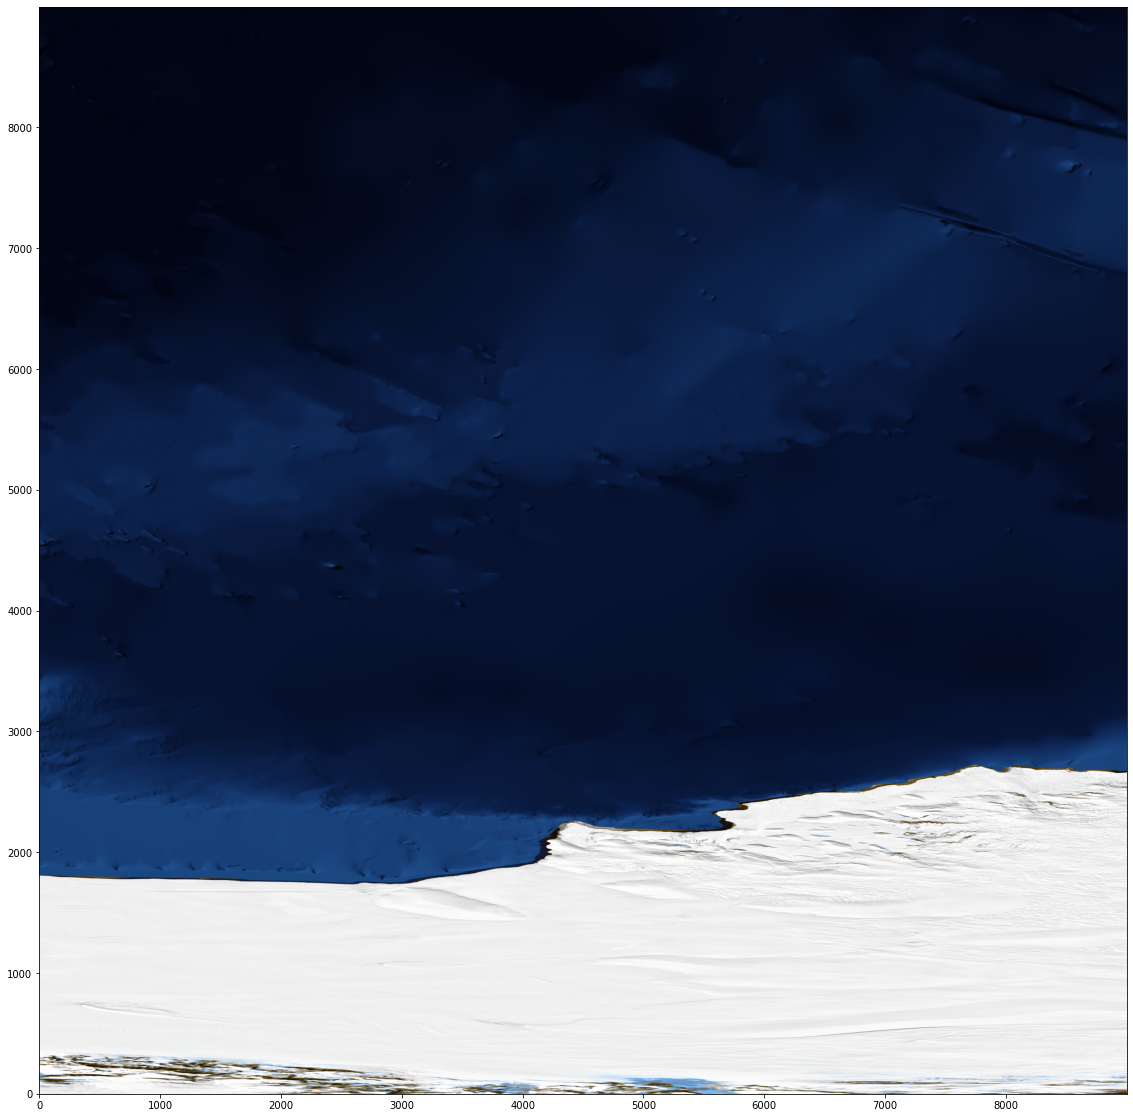

In [3]:
ShowData(ds.data[1000:10000,1000:10000,:].values)


Adding field data shape [70416, 29280, 3] dtype uint8 labels ['y', 'x', 'channel']
_raw_indexing_method key (slice(10000, 11000, 1), slice(10000, 11000, 1), slice(0, 3, 1))


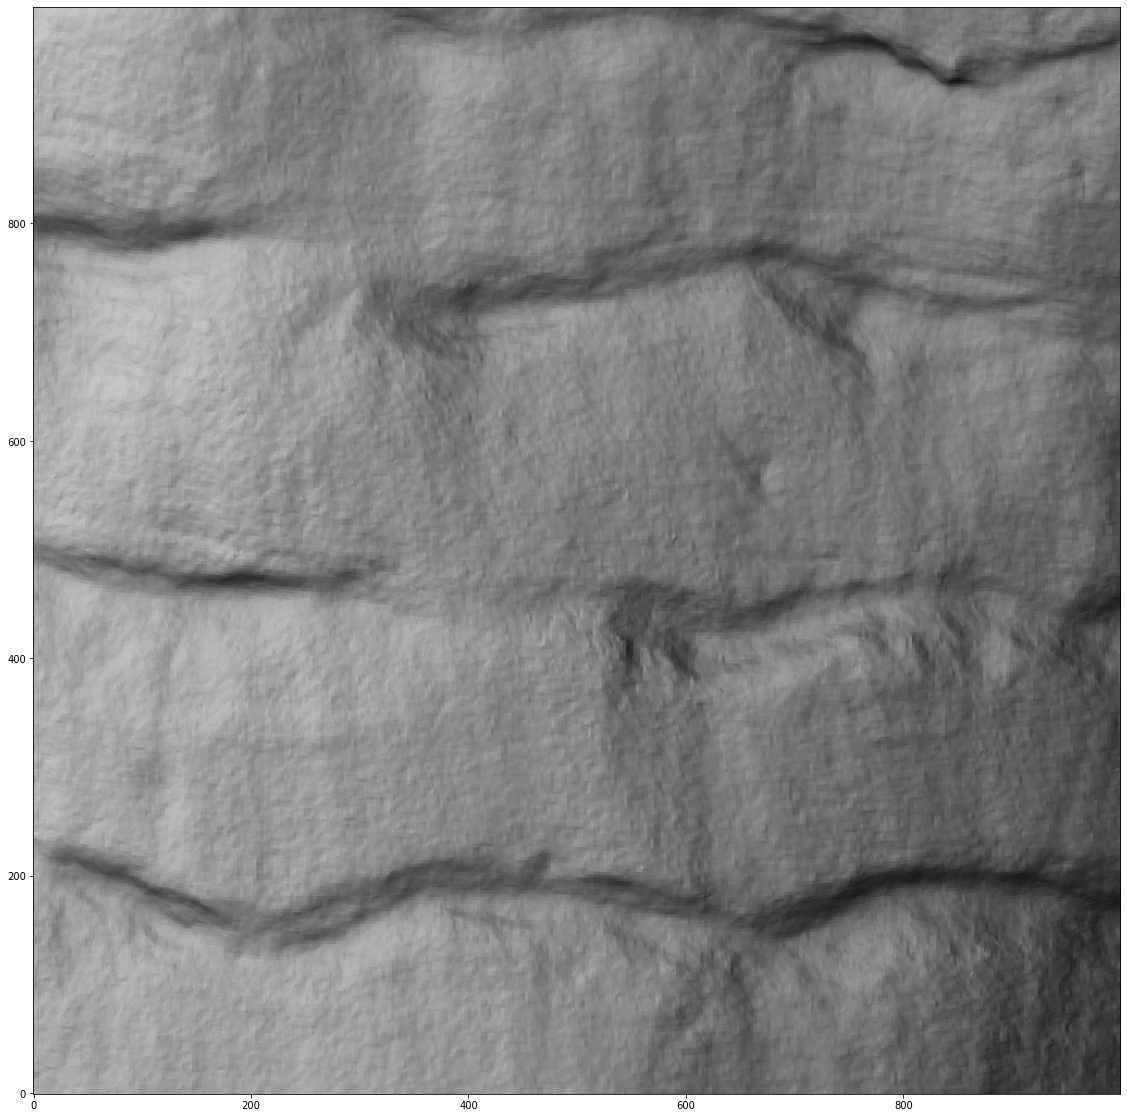

In [100]:
db=xr.open_dataset('http://atlantis.sci.utah.edu/mod_visus?dataset=david_subsampled', engine=OpenVisusBackendEntrypoint)
"""
Using sel() method from Xarray on OpenVisus to slice up the data and select certain certain range values of x and y
"""
# print(db.data[10000:11000,10000:11000,:].values)
# ShowData(db.data[10000:11000,10000:11000,:].values)
ShowData(db.sel(x=slice(10000,11000),y=slice(10000,11000),channel=slice(0,3)).data.values)

Adding field DATA shape [2048, 2048, 2048] dtype uint8 labels ['z', 'y', 'x']
_raw_indexing_method key (slice(1024, 1025, 1), slice(0, 2048, 1), slice(0, 2048, 1))


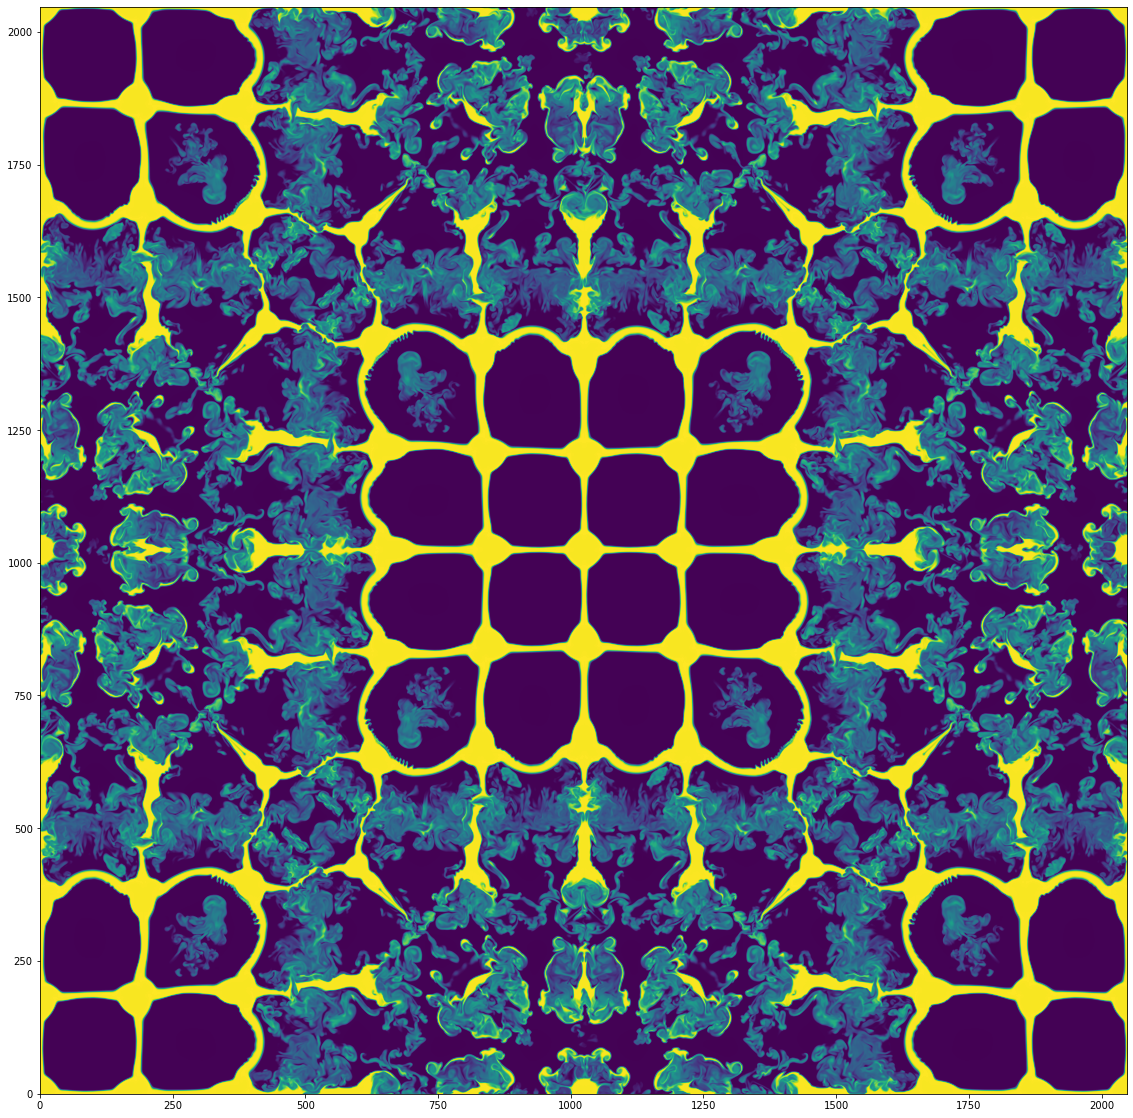

In [99]:
db2=xr.open_dataset('http://atlantis.sci.utah.edu/mod_visus?dataset=2kbit1', engine=OpenVisusBackendEntrypoint)
select_db2=db2.sel(x=slice(0,2048),y=slice(0,2048),z=slice(1024,1025)).to_array()

ShowData(select_db2[0][0].values)


In [69]:
db=xr.open_dataset('http://atlantis.sci.utah.edu/mod_visus?dataset=david_subsampled', engine=OpenVisusBackendEntrypoint)

def ShowImage(data,width=10):
    ratio=float(data.shape[1])/data.shape[0]
    fig = plt.figure(figsize = (width,width*ratio))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(data, origin='lower')
    plt.show()

# Doesn't work for normalized coordinates yet

# ShowData(db.data[0.35:0.45,0.8:0.9,:].values)

Adding field data shape [70416, 29280, 3] dtype uint8 labels ['y', 'x', 'channel']
